## Data Preprocessing


In [377]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
from geopy import merge_geodata
from geopy import get_geodata
from date_pyler import applier_cwise
from date_pyler import to_date
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

df = pd.read_csv("data/Train.csv")
df = df.set_index("ID")

## Geodata


In [378]:
# add geodata to dataframe
geo_data = get_geodata(df.DEPSTN, df.ARRSTN)

df_geo = merge_geodata(df, geo_data, "DEPSTN")
df_geo = merge_geodata(df_geo, geo_data, "ARRSTN")

## Date data type convertion


In [379]:
# columnwise datetype conversion on dataframe
date_order = [
    ["%Y", "%m", "%d", "%H", "%M", "%S"],
    ["%Y", "%m", "%d", "%H", "%M", "%S"],
    ["%Y", "%m", "%d"],
]
applier_cwise(df_geo, ["STD", "STA", "DATOP"], to_date, orders=date_order)


df_geo["date_dep_year"] = df_geo.DATOP.dt.year.astype(int)
df_geo["date_dep_month"] = df_geo.DATOP.dt.month.astype(int)
df_geo["date_dep_day_year"] = df_geo.DATOP.dt.day_of_year.astype(int)
df_geo["date_dep_day_week"] = df_geo.DATOP.dt.day_of_week.astype(int)
df_geo["date_dep_hour"] = df_geo.STD.dt.hour.astype(int)
df_geo["date_dep_minute"] = df_geo.STD.dt.minute.astype(int)
df_geo["flight_duration"] = (
    (df_geo.STA - df_geo.STD).astype("timedelta64[m]").astype(int)
)
df_geo["min_of_day"] = (df_geo.STD.dt.hour * 60 + df_geo.STD.dt.minute).astype(int)

## FLIGHT STATUS


<AxesSubplot:xlabel='STATUS', ylabel='target'>

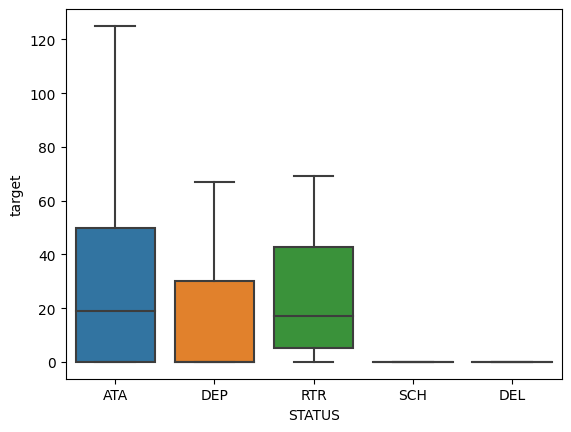

In [380]:
df_geo.STATUS.unique()


sns.boxplot(data=df_geo, x="STATUS", y="target", showfliers=False)

## FLIGHT ID


### Airlines from Flight ID


In [381]:
df_geo["exec_airline"] = df_geo.FLTID.str.split().str[0]
# df_geo[df_geo.exec_airline != df_geo.owner_airline]
df_geo.exec_airline.value_counts()


TU     92443
UG     9434 
WKL    3105 
AOG    1103 
AT     874  
INT    282  
A      251  
SGT    227  
20M    29   
C      24   
PRO    23   
GJT    22   
6YE    6    
DAT    3    
D4     2    
UH     2    
12Y    1    
AUI    1    
X9     1    
Name: exec_airline, dtype: int64

## Feature selection


In [382]:
df_geo.isna().sum()

DATOP                0  
FLTID                0  
DEPSTN               0  
ARRSTN               0  
STD                  0  
STA                  0  
STATUS               0  
AC                   0  
target               0  
iata_DEPSTN          332
country_DEPSTN       332
lat_DEPSTN           332
lon_DEPSTN           332
elevation_DEPSTN     332
iata_ARRSTN          332
country_ARRSTN       332
lat_ARRSTN           332
lon_ARRSTN           332
elevation_ARRSTN     332
date_dep_year        0  
date_dep_month       0  
date_dep_day_year    0  
date_dep_day_week    0  
date_dep_hour        0  
date_dep_minute      0  
flight_duration      0  
min_of_day           0  
exec_airline         0  
dtype: int64

In [383]:
df_geo = df_geo.dropna()

In [384]:
features = [
    "date_dep_year",
    "date_dep_month",
    "date_dep_day_year",
    "date_dep_day_week",
    "date_dep_hour",
    "date_dep_minute",
    "flight_duration",
    "lat_DEPSTN",
    "lon_DEPSTN",
    "elevation_DEPSTN",
    "lat_ARRSTN",
    "lon_ARRSTN",
    "elevation_ARRSTN",
    "exec_airline",
    "STATUS",
]

X = df_geo[features]
y = df_geo.target




                   date_dep_year  date_dep_month  date_dep_day_year  \
date_dep_year     NaN            -5.63e-02       -6.00e-02            
date_dep_month    -5.63e-02      NaN             NaN                  
date_dep_day_year -6.00e-02      NaN             NaN                  
date_dep_day_week -1.19e-02       5.79e-03        4.99e-03            
date_dep_hour      2.37e-03       3.43e-03        3.33e-03            
date_dep_minute   -1.32e-03      -1.70e-03       -1.64e-03            
flight_duration    3.91e-03      -4.21e-04        2.97e-05            
lat_DEPSTN        -1.81e-02       2.80e-02        2.78e-02            
lon_DEPSTN         6.11e-03      -3.73e-02       -3.70e-02            
elevation_DEPSTN   2.14e-02       7.23e-04        8.85e-04            
lat_ARRSTN        -1.85e-02       2.80e-02        2.79e-02            
lon_ARRSTN         6.13e-03      -3.70e-02       -3.68e-02            
elevation_ARRSTN   2.21e-02       1.50e-03        1.63e-03            

     

<AxesSubplot:>

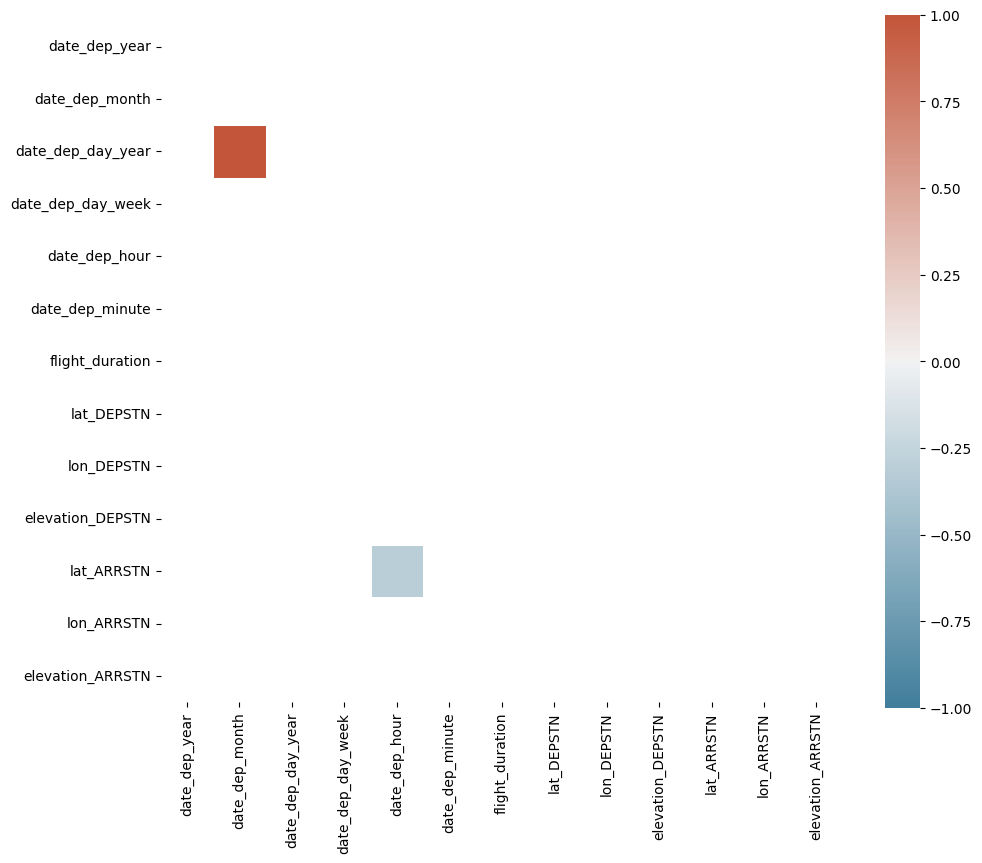

In [385]:
#correlation
corr = X.corr()
print(corr[abs(corr)<0.5])
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr[abs(corr)>0.3], mask=mask, cmap=cmap, vmax=1, center=0, vmin=-1,
            square=True, linewidths=.5,) #cbar_kws={"shrink": .5})


In [386]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
    
)
def OneHot(X_train = X_train, X_test = X_test, column = 'STATUS', drop="first", handle_unknown="ignore", sparse=False):
    onehot = OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)

    STATUS_onehot_train = onehot.fit_transform(X_train[column].to_numpy().reshape(-1, 1))
    STATUS_onehot_df_train = pd.DataFrame(STATUS_onehot_train,columns=[column + '_' + x for x in onehot.categories_[0][1:]])


    STATUS_onehot_test = onehot.transform(X_test[column].to_numpy().reshape(-1, 1))
    STATUS_onehot_df_test = pd.DataFrame(STATUS_onehot_test,columns=[column + '_' + x for x in onehot.categories_[0][1:]])



    X_train = pd.concat([X_train, STATUS_onehot_df_train.set_index(X_train.index)], axis = 1)
    X_test = pd.concat([X_test, STATUS_onehot_df_test.set_index(X_test.index)], axis = 1)

    X_train.drop(column, axis = 1, inplace = True)
    X_test.drop(column, axis = 1, inplace = True)
    return X_train, X_test

In [387]:
X_train, X_test = OneHot(X_train = X_train, X_test = X_test, column= 'STATUS')



In [388]:
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


ValueError: could not convert string to float: 'TU'

In [ ]:
y_train

2074      25.0 
107629    0.0  
89990     42.0 
67515     0.0  
24994     48.0 
          ...  
55259     190.0
77308     0.0  
104355    0.0  
867       30.0 
15918     30.0 
Name: target, Length: 91096, dtype: float64

In [ ]:
lin_reg = LinearRegression()


In [ ]:
lin_reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
import matplotlib.pyplot as plt
# fig,ax = plt.subplots()
# fig.set_size_inches(18.5, 10.5)
# plt.bar(X_train.columns.tolist(), lin_reg.coef_)
# plt.xticks(rotation=90)

print(*sorted(list(zip(X_train.columns.tolist(), lin_reg.coef_)),key = lambda x: x[1]), sep = '\n')

('exec_airline_X9', -117.13120378253977)
('exec_airline_D4', -97.40736017661186)
('exec_airline_GJT', -80.26919367486252)
('STATUS_DEL', -54.597778174144175)
('exec_airline_WKL', -54.04040738260063)
('exec_airline_INT', -52.431793725779585)
('STATUS_SCH', -51.88191588704749)
('exec_airline_AT', -49.38801849894065)
('exec_airline_PRO', -45.064972536085364)
('exec_airline_UG', -44.96384075698877)
('exec_airline_AOG', -43.96806808033335)
('exec_airline_UH', -43.12809869726592)
('exec_airline_TU', -39.61424502932392)
('lat_DEPSTN', -38.86636613963347)
('exec_airline_SGT', -36.95609543181956)
('exec_airline_C', -36.748649881783436)
('exec_airline_A', -36.451444874701146)
('exec_airline_20M', -26.190368427079598)
('exec_airline_6YE', -24.88257799297281)
('lat_ARRSTN', -10.649341461297889)
('STATUS_DEP', -5.003556041333183)
('elevation_ARRSTN', -4.195786719893487)
('date_dep_day_year', -2.547779122327147)
('date_dep_day_week', 9.905072556110635)
('date_dep_month', 10.981530800343457)
('date_d

In [ ]:
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

In [ ]:
rmse_linreg_test = mean_squared_error(y_test,y_test_pred, squared=False)
r2_linreg_test = r2_score(y_test,y_test_pred)
rmse_linreg_train = mean_squared_error(y_train,y_train_pred, squared=False)
r2_linreg_train = r2_score(y_train,y_train_pred)

In [ ]:
print('LINREGSCORES')
print('TRAIN SCORE')
print(f'RMSE: {rmse_linreg_train}')
print(f'r2: {r2_linreg_train}')
print()
print('TEST SCORE')
print(f'RMSE: {rmse_linreg_test}')
print(f'r2: {r2_linreg_test}')

LINREGSCORES
TRAIN SCORE
RMSE: 114.6784661583737
r2: 0.04323318918779917

TEST SCORE
RMSE: 110.06662833462664
r2: 0.047386217931842944


In [ ]:
poly = PolynomialFeatures(interaction_only = True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)



In [ ]:
lin_reg.fit(X_train_poly, y_train)

LinearRegression()

In [ ]:
y_train_pred = lin_reg.predict(X_train_poly)
y_test_pred = lin_reg.predict(X_test_poly)

In [ ]:
rmse_linreg_test = mean_squared_error(y_test,y_test_pred, squared=False)
r2_linreg_test = r2_score(y_test,y_test_pred)
rmse_linreg_train = mean_squared_error(y_train,y_train_pred, squared=False)
r2_linreg_train = r2_score(y_train,y_train_pred)

In [ ]:
print('LINREGSCORES with Polyfeatures')
print('TRAIN SCORE')
print(f'RMSE: {rmse_linreg_train}')
print(f'r2: {r2_linreg_train}')
print()
print('TEST SCORE')
print(f'RMSE: {rmse_linreg_test}')
print(f'r2: {r2_linreg_test}')

LINREGSCORES with Polyfeatures
TRAIN SCORE
RMSE: 113.66477898999283
r2: 0.06007289377231917

TEST SCORE
RMSE: 242658857032.5558
r2: -4.630179521633289e+18


In [ ]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()

feat_train = X_train
tar_train = y_train
feat_test = X_test
tar_test = y_test


xgb_model.fit(feat_train,tar_train)

y_test_pred = xgb_model.predict(feat_test)
y_train_pred = xgb_model.predict(feat_train)

rmse_xgb_test = mean_squared_error(tar_test,y_test_pred, squared=False)
r2_xgb_test = r2_score(tar_test,y_test_pred)
rmse_xgb_train = mean_squared_error(tar_train,y_train_pred, squared=False)
r2_xgb_train = r2_score(tar_train,y_train_pred)


In [267]:
print('XGB Scores ')
print('TRAIN SCORE')
print(f'RMSE: {rmse_xgb_train}')
print(f'r2: {r2_xgb_train}')
print()
print('TEST SCORE')
print(f'RMSE: {rmse_xgb_test}')
print(f'r2: {r2_xgb_test}')

XGB Scores 
TRAIN SCORE
RMSE: 94.02532601335824
r2: 0.3568207181453654

TEST SCORE
RMSE: 104.81079128243987
r2: 0.13619137910849932


### Grid search with xgb

In [275]:
from sklearn.model_selection import RandomizedSearchCV


param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [5,7,9],
    'max_leaves': [10,25],
    'learning_rate': [.001, 0.01]

}

estimator  = XGBRegressor()

gs = RandomizedSearchCV(estimator, param_grid, n_jobs = 3, 
                        scoring = 'neg_root_mean_squared_error', cv = 3, verbose = 5)

In [276]:
gs.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 3/3] END learning_rate=0.01, max_depth=7, max_leaves=25, n_estimators=100;, score=-117.779 total time=   7.0s
[CV 2/3] END learning_rate=0.01, max_depth=7, max_leaves=25, n_estimators=100;, score=-112.892 total time=   7.1s
[CV 1/3] END learning_rate=0.01, max_depth=7, max_leaves=25, n_estimators=100;, score=-112.138 total time=   7.3s
[CV 1/3] END learning_rate=0.001, max_depth=7, max_leaves=25, n_estimators=500;, score=-115.897 total time=  29.7s
[CV 3/3] END learning_rate=0.001, max_depth=7, max_leaves=25, n_estimators=500;, score=-121.320 total time=  30.0s
[CV 2/3] END learning_rate=0.001, max_depth=7, max_leaves=25, n_estimators=500;, score=-116.563 total time=  30.7s
[CV 1/3] END learning_rate=0.001, max_depth=9, max_leaves=25, n_estimators=500;, score=-115.203 total time=  40.8s
[CV 2/3] END learning_rate=0.001, max_depth=9, max_leaves=25, n_estimators=500;, score=-116.103 total time=  41.2s
[CV 3/3] END learning_

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          min_child_weight=None, missing=nan,
                            

In [281]:
y_test_pred = gs.best_estimator_.predict(X_test)
y_train_pred = gs.best_estimator_.predict(X_train)

In [282]:
rmse_xgb_test = mean_squared_error(tar_test,y_test_pred, squared=False)
r2_xgb_test = r2_score(tar_test,y_test_pred)
rmse_xgb_train = mean_squared_error(tar_train,y_train_pred, squared=False)
r2_xgb_train = r2_score(tar_train,y_train_pred)


In [283]:
print('XGB Scores ')
print('TRAIN SCORE')
print(f'RMSE: {rmse_xgb_train}')
print(f'r2: {r2_xgb_train}')
print()
print('TEST SCORE')
print(f'RMSE: {rmse_xgb_test}')
print(f'r2: {r2_xgb_test}')

XGB Scores 
TRAIN SCORE
RMSE: 103.55278690282685
r2: 0.2198718780239416

TEST SCORE
RMSE: 104.91104202153342
r2: 0.13453813583978536


## choose less features

In [389]:
features_small = [
    "date_dep_day_year",
    "date_dep_day_week",
    "min_of_day",
    "flight_duration",
    "lat_DEPSTN",
    "lon_DEPSTN",
    "lat_ARRSTN",
    "lon_ARRSTN",
    "exec_airline", #is Tunesian Airline Yes/No
    "STATUS",
]

X_less = df_geo[features_small]
y_less = df_geo.target
X_less['exec_airline'] = np.where(X_less['exec_airline'] == 'TU', 1, 0)

/var/folders/5z/wvdyq1hd6t7601xb2n5v_m880000gn/T/ipykernel_2667/1390453627.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_less['exec_airline'] = np.where(X_less['exec_airline'] == 'TU', 1, 0)


,date_dep_day_year,date_dep_day_week,min_of_day,flight_duration,lat_DEPSTN,lon_DEPSTN,lat_ARRSTN,lon_ARRSTN,exec_airline,STATUS
0,3,6,630,145,33.37,-7.59,36.85,10.23,1,ATA
1,13,2,905,110,45.63,8.73,36.85,10.23,1,ATA
2,16,5,250,155,36.85,10.23,41.28,28.75,1,ATA
3,17,6,850,170,33.88,10.78,47.15,-1.61,1,ATA
4,17,6,870,80,36.85,10.23,36.69,3.22,1,ATA
...,...,...,...,...,...,...,...,...,...,...
107828,186,3,1380,180,36.85,10.23,36.85,10.23,0,SCH
107829,13,5,480,60,33.88,10.78,36.85,10.23,0,SCH
107830,311,2,300,470,36.85,10.23,36.85,10.23,0,SCH
107831,23,1,1080,45,36.85,10.23,33.88,10.78,0,ATA
